In [308]:
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [309]:
FS = 44100 #sampling frequency

In [310]:
def create_t(length_seconds):
    return np.linspace(0, length_seconds, int(FS*length_seconds))

In [311]:
bitT = 0.01

In [312]:
S0 = np.sin(create_t(bitT)*2*np.pi* 1300)
S1 = np.sin(create_t(bitT)*2*np.pi*1700)

In [396]:
synT = create_t(bitT*10)
synS = np.cos(synT*2*np.pi*1500)

In [397]:
sd.play(synS, FS)

In [391]:
get_pulse = {'0':S0, '1':S1}

In [315]:
STR = "Hello, world"

In [316]:
def str2bits(str):
    res = bin(int.from_bytes(str.encode('ascii'), 'big'))[2:]
    return '0'*(8 - (len(res) % 8)) + res

In [317]:
r = str2bits(STR)

In [318]:
r

'010010000110010101101100011011000110111100101100001000000111011101101111011100100110110001100100'

In [319]:
0b01100100

100

In [398]:
def send(binstream):
    SigLen = S0.size
    n = len(binstream)
    S = np.empty(n*SigLen + synS.size)
    c = 0
    S[:synS.size] = synS
    for b in binstream:
        S[c*SigLen + synS.size:(c+1)*SigLen + synS.size] = get_pulse[b]
        c+=1 
    return S

In [399]:
W = send(r)

In [400]:
sd.play(W)

In [401]:
%%time
np.correlate(W, synS, 'valid')

CPU times: user 50 ms, sys: 10 ms, total: 60 ms
Wall time: 54.2 ms


array([ 2.20550000e+03,  2.15432495e+03,  2.00531338e+03, ...,
        4.70174331e+00,  2.39977527e+00, -7.14398093e-02])

In [402]:
def decode(W):
    corr = np.correlate(W, synS, 'valid')
    start_syn = np.argmax(corr)
    start = start_syn + synS.size
    result = ''
    rlen = int((W.size)/(bitT*FS))
    for i in range(len(STR)*8):
        symStart = start + int(i*bitT*FS)
        symEnd = symStart + int(bitT*FS)
        S0max = np.max(np.correlate(W[symStart:symEnd], S0[:S0.size//2]))
        S1max = np.max(np.correlate(W[symStart:symEnd], S1[:S1.size//2]))
        result += '0' if S0max > S1max else '1'
    return result

In [403]:
decode(np.hstack((np.random.normal(0, 1, 1050), W, np.random.normal(0,1, 1000))))

'010010000110010101101100011011000110111100101100001000000111011101101111011100100110110001100100'

In [404]:
r

'010010000110010101101100011011000110111100101100001000000111011101101111011100100110110001100100'

In [405]:
r == decode(W)

True

In [406]:
%%time
decode(W)

CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 58 ms


'010010000110010101101100011011000110111100101100001000000111011101101111011100100110110001100100'

In [418]:
sigma = 1
Wnoise = W + np.random.normal(0, sigma, W.size)
decode(Wnoise + 2) == r

True

In [412]:
np.min(Wnoise)

-4.8454842599880426

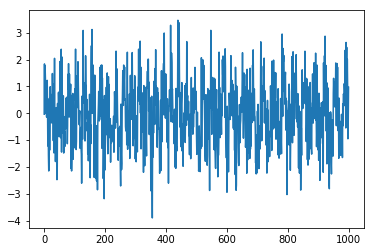

In [413]:
plt.plot(Wnoise[44000:45000])

In [383]:
sd.play(Wnoise, FS)